# Plot long timeseries of CTD data

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from datetime import datetime
from datetime import timedelta
import gsw

In [2]:
df = pd.read_csv('../../data/ISA_CTD/ctd_isa_all_processed.csv',index_col=0)
df

,Latitude,Longitude,Pressure,Date,Time,SA,CT
0,78.257,15.5266,1,2011-12-14 12:05:34,0.0,34.478605,0.846132
1,78.257,15.5266,2,2011-12-14 12:05:34,0.0,34.453490,0.846728
2,78.257,15.5266,3,2011-12-14 12:05:34,0.0,34.463543,0.844132
3,78.257,15.5266,4,2011-12-14 12:05:34,0.0,34.473596,0.843536
4,78.257,15.5266,5,2011-12-14 12:05:34,0.0,34.458529,0.846576
...,...,...,...,...,...,...,...
18316,78.257,15.5267,61,2018-09-12 19:15:48,212915414.0,34.696629,3.467051
18317,78.257,15.5267,62,2018-09-12 19:15:48,212915414.0,34.696934,3.464486
18318,78.257,15.5267,63,2018-09-12 19:15:48,212915414.0,34.697539,3.463017
18319,78.257,15.5267,64,2018-09-12 19:15:48,212915414.0,34.700356,3.459529


In [40]:
pressure_array = np.arange(np.min(df['Pressure']),np.max(df['Pressure'])+1,1)
time_array = np.arange(np.min(df['Time']),np.max(df['Time'])+1,60*60*24*7) # 1 week spacing

Time, Pressure = np.meshgrid(time_array,pressure_array)

SA_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['SA'],xi=(Time,Pressure),method='nearest')
CT_interp = scipy.interpolate.griddata(points=(df['Time'],df['Pressure']),values=df['CT'],xi=(Time,Pressure),method='nearest')

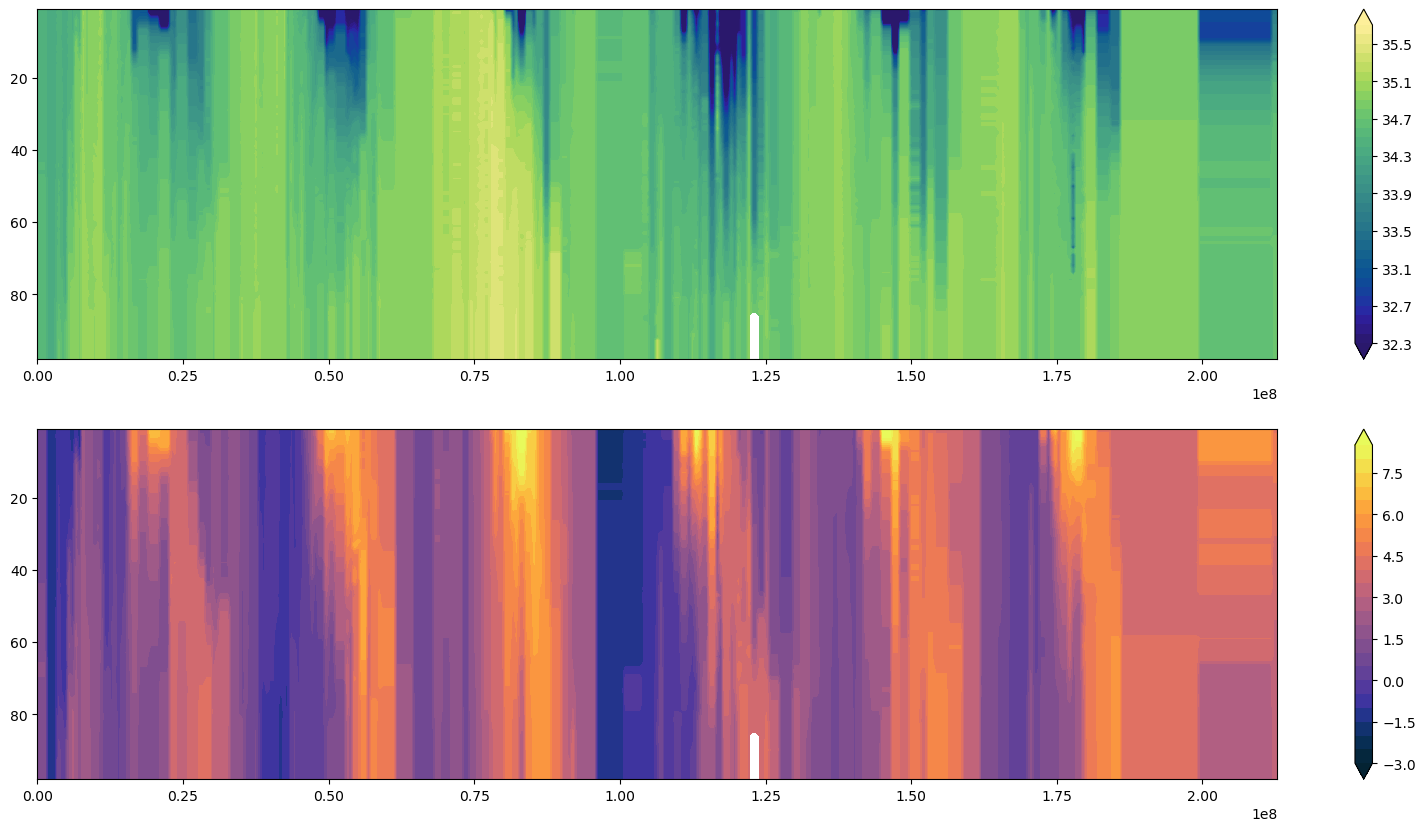

In [41]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10))
plot_SA = ax1.contourf(Time,Pressure,SA_interp,levels=np.arange(32.3,35.8,0.1),extend='both',cmap='cmo.haline')
cbar_SA = plt.colorbar(plot_SA,ax=ax1)
ax1.set_ylim(ax1.get_ylim()[::-1])

plot_CT = ax2.contourf(Time,Pressure,CT_interp,levels=np.arange(-3,9,0.5),extend='both',cmap='cmo.thermal')
cbar_CT = plt.colorbar(plot_CT,ax=ax2)
ax2.set_ylim(ax2.get_ylim()[::-1])

plt.show()

# TODO:
# - ticks on time axis
# - ticks on vertical axis as depths? With mean lat and lon
# - labels on horizontal and vertical axes, colorbars, titles
# - adjust colorbar ranges

In [ ]:
def plotTimeDepth(ax,Time,Vert,data,levels,cmap,verttype,maxv,label,title,inv_cbar=False):
    plot = ax.contourf(Time,Vert,data,levels=levels,extend='both',cmap=cmap)
    cbar = plt.colorbar(plot, ax=ax)
    if verttype=='depth':
        ax.set_ylabel('Depth (m)', fontsize=15)
    else:
        ax.set_ylabel('Pressure (dbar)', fontsize=15)
    ax.set_ylim(0,maxv)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks(time[0::24])
    ax.set_xticklabels([dates[i].year for i in np.arange(0,len(time[0::24])*24,24)])
    ax.set_title(title,fontsize=17)
    cbar.ax.set_ylabel(label,fontsize=14)
    cbar.ax.tick_params(axis='y', which='both', labelsize=14)
    cbar.ax.get_yaxis().labelpad = 25
    if inv_cbar:
        cbar.ax.invert_yaxis()